In [1]:
# %pip install pandas nltk numpy torch torchvision
# import nltk
# nltk.download('punkt')
# pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 --extra-index-url https://download.pytorch.org/whl/cu117 --no-cache-dir

In [2]:
import pandas as pd
import json
from nltk.tokenize import word_tokenize
import numpy as np
import re
import random
import matplotlib.pyplot as plt

In [3]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

d:\Apps\anaconda3\envs\comp90042Project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.cuda.is_available()

True

In [5]:
import math
from tqdm import tqdm, tqdm_notebook # show progress bar
# from sklearn.metrics import f1_score

import warnings

# 1. Preprocess the data

In [6]:
# Read evidence
with open('../data/evidence.json', 'r') as f:
    evidence = json.load(f)
eviden = pd.DataFrame.from_dict(evidence, orient='index', columns=['evidence'])
ev_txt = eviden['evidence'].values
max_len = max([len(j.split()) for i,j in evidence.items()])

# Read train claims
with open('../data/train-claims.json', 'r') as f:
    df_train = pd.DataFrame(json.load(f)).transpose()

# Read dev claims
with open('../data/dev-claims.json', 'r') as f:
    df_dev = pd.DataFrame(json.load(f)).transpose()

# Read test claims
with open('../data/test-claims-unlabelled.json', 'r') as f:
    df_test = pd.DataFrame(json.load(f)).transpose()

In [7]:
# Tokenizer function (Map words to indexes)
class token:
    def __init__(self):
        self.word2index = {"[PAD]": 0, "[CLS]": 1, "[SEP]": 2, "[MASK]": 3}
        self.index2word = {0: "[PAD]", 1: "[CLS]", 2: "[SEP]", 3: "[MASK]"}
        self.n_words = 4  # Count CLS and SEP

    def addSentence(self, sentence):
        for word in sentence.split():
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

# tokenizer function
tokenizer = token()
def tok(corpus):
    [tokenizer.addSentence(i) for i in corpus]

# Function to get negative relations
def neg(claims, number):
    # Define lists
    tok_ev, tok_cl, label = [], [], []
    # Get negative list
    negative = eviden.sample(n = number)['evidence'].values
    for cl in claims:
        # Add negative relations to list
        tok_ev.extend(negative)
        tok_cl.extend([cl] *len(negative))
        label.extend([0] * len(negative))
    return tok_ev, tok_cl, label 

In [8]:
# Process of tokenization and string removal from evidence dataset. File saved to reduce memory usage
if not os.path.exists('../data/evidence_tokenized.json'):
    # Tokenize and lower text
    ev = [word_tokenize(i.lower()) for i in ev_txt]
    # Drop unknown characters
    ev_txt = [' '.join([w for w in seq if re.match('^[\w\d]+$', w)]) for seq in ev]
    with open('../data/evidence_tokenized.json', 'w') as f:
        json.dump(ev_txt, f)
else:
    with open('../data/evidence_tokenized.json', 'r') as f:
        ev_txt = json.load(f)
        tok(ev_txt)
        eviden['evidence'] = ev_txt

In [9]:
LABEL_DICTIONARY = {}
ID_DICTIONARY = {}
for i, label in enumerate(df_train['claim_label'].unique()):
    LABEL_DICTIONARY[label] = i
    ID_DICTIONARY[i] = label
LABEL_DICTIONARY

{'DISPUTED': 0, 'REFUTES': 1, 'SUPPORTS': 2, 'NOT_ENOUGH_INFO': 3}

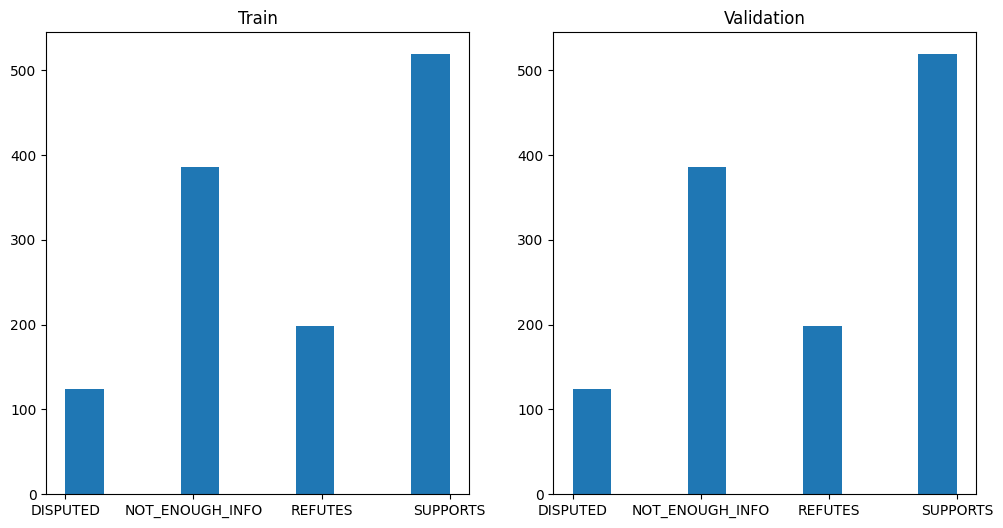

In [50]:
# Label Distribution
fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].set_title("Train")
axs[1].set_title("Validation")
tlabel = axs[0].hist(sorted([l for l in df_train['claim_label']]))
vlabel = axs[1].hist(sorted([l for l in df_train['claim_label']]))

In [51]:
# Helper function to prepare datasets
def prepare_df(df):
    # Support labels
    df_1 = df.explode("evidences")
    df_1['evidences_text'] = [evidence[item] for item in df_1['evidences']]
    df_1['label'] = 1
    # Refuse labels
    df_2 = df_1[['claim_text']].copy()
    df_2['evidences_text'] = [random.choice(ev_txt) for i in range(df_2.shape[0])]
    df_2['label'] = 0
    df = pd.concat([df_1[['claim_text' , 'evidences_text', 'label']], df_2]).sample(frac=1)
    return df

df = prepare_df(df_train)
df

,claim_text,evidences_text,label
claim-2130,Plant stomata show higher and more variable CO...,in some places the rain fell over 50 mm in an ...,0
claim-44,Human-produced carbon might be one of the fact...,more recent studies of seafloor microbes cast ...,0
claim-1774,The CERN CLOUD experiment only tested one-thir...,This result does not support the hypothesis th...,1
claim-2020,Weather Channel Co-Founder John Coleman Calls ...,confused by the conflicting indications an ope...,0
claim-1112,“The jet stream forms a boundary between the c...,it lies south of wellington and has a populati...,0
...,...,...,...
claim-1367,But we do have other reliable indicators of te...,shortly thereafter agramunt himself was one of...,0
claim-450,If we double atmospheric carbon dioxide[…] we’...,globally during the 1980s one new nuclear reac...,0
claim-1506,Most likely the primary control knob on climat...,"United States Secretary of Energy Rick Perry, ...",1
claim-710,"With marine ice cliff instability, sea-level r...",According to the Fourth (2017) National Climat...,1


In [ ]:
# Helper function to prepare datasets
def prepare_df(df):
    # Support labels
    df_1 = df.explode("evidences")
    df_1['evidences_text'] = [evidence[item] for item in df_1['evidences']]
    df_1['label'] = 1
    # Refuse labels
    df_2 = df_1[['claim_text']].copy()
    df_2['evidences_text'] = [random.choice(ev_txt) for i in range(df_2.shape[0])]
    df_2['label'] = 0
    df = pd.concat([df_1[['claim_text' , 'evidences_text', 'label']], df_2]).sample(frac=1)
    return df

# Select columns to work on and retrieve tokenized and preprocesed vectors 
def feature_selection(df):
    # Prepare df
    df_ = prepare_df(df)
    # Set words to lower and tokenize
    tok_evidence = [word_tokenize(i.lower()) for i in df_['evidences_text']]
    tok_claim = [word_tokenize(i.lower()) for i in df_['claim_text']]
    # Drop unknown characters (This may be modified depending model performance)
    tok_evidence = [' '.join([w for w in seq if re.match('^[\w\d]+$', w)]) for seq in tok_evidence]
    tok_claim = [' '.join([w for w in seq if re.match('^[\w\d]+$', w)]) for seq in tok_claim]
    # Class label
    label = df_['label']
    return tok_claim, tok_evidence, label

# Get data features
tr_tok_cl, tr_tok_ev, tr_label = feature_selection(df_train)

In [ ]:
pd.Series(tr_label).value_counts()

In [ ]:
# Preprocess dev set
# Instanciate lists
dv_tok_ev = []
dv_tok_cl = []
# Get positive pair relations
positive = df_dev.explode('evidences')[['claim_text', 'evidences']]
# Add positive relations to list
dv_tok_ev.extend([eviden.loc[i].values[0] for i in positive['evidences']])
dv_tok_cl.extend(positive['claim_text'].values)
dv_label =[1] * len(positive)

# Create negative relations
negative = neg(dv_tok_cl, 1)
dv_tok_ev.extend(negative[0])
dv_tok_cl.extend(negative[1])
dv_label.extend(negative[2])

In [ ]:
pd.Series(dv_label).value_counts()

In [ ]:
# Prepare test to tokenize
claim_test = [word_tokenize(i.lower()) for i in df_test['claim_text']]
claim_test = [' '.join([w for w in seq if re.match('^[\w\d]+$', w)]) for seq in claim_test]

In [ ]:
# Add tokens to dict
tok(ev_txt)
tok(tr_tok_cl)
tok(dv_tok_cl)
tok(claim_test)

# 2. Model the data

### Load the data to tensor batches

<center><h3> 2.1 Bert embeding</h3></center>

<center><img src=../main/Images/BERT_emb.png alt="drawing" width="500"></center>
<center><img src=../Images/BERT_emb_example.png alt="drawing" width="500"></center>

In [ ]:
# Dataset class
class Dataset(Dataset):
    def __init__(self, texts, tokenizer, seq_len=max_len):
        self.text = texts
        self.tokenizer = tokenizer
        self.seq_len = seq_len
    def __len__(self):
        return len(self.text)
    def __getitem__(self, idx):
        # Step 1: get text tokens
        sent = [self.tokenizer.word2index[i] for i in self.text[idx].split()]
        
        # Step 2: replace random words in sentence with mask / random words
        sent_mask, labels = self.masking(sent)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentence
        # Adding PAD token for labels
        sent = [self.tokenizer.word2index['[CLS]']] + sent_mask + [self.tokenizer.word2index['[SEP]']]
        labels = [self.tokenizer.word2index['[PAD]']] + labels + [self.tokenizer.word2index['[PAD]']]

        # Step 4: Add PAD tokens to make the sentence same length as seq_len
        padding = [self.tokenizer.word2index['[PAD]'] for empty in range(self.seq_len - len(sent))]
        sent.extend(padding)
        labels.extend(padding)
        return np.array(sent), np.array(labels)
    
    #------------------------------------------------------------------------------------------
    # Function to mask/randomize tokens
    def masking(self, tokens, to_replace = 0.15):
        # tokens = input.split()
        output = []
        label = []
        for token in tokens:
            prob = random.random()
            # 15% of the tokens would be replaced
            if prob <= to_replace:
                # 10% chance change token to current token
                if prob < to_replace*.1:
                    output.append(token)
                # 10% chance change token to random
                elif prob < to_replace*.1*2:
                    output.append(random.choice(list(self.tokenizer.word2index.values())))
                # 10% chance change token to random
                else:
                    output.append(self.tokenizer.word2index["[MASK]"])
                label.append(token)
            else:
                output.append(token)
                label.append(0)
        return output, label

In [ ]:
# Define collate (pre_process) function
def collate_batch(batch):
    texts, labels = zip(*batch)
    texts = torch.from_numpy(np.array(texts)).to(device)
    labels = torch.from_numpy(np.array(labels)).to(device)
    return texts, labels

# Instanciate DataLoader
bs = 32

# ______________________________Traing data______________________________
# Datasets
tr_ev_ds = Dataset(tr_tok_ev, tokenizer)
tr_cl_ds = Dataset(tr_tok_cl, tokenizer)

# Dataloaders
tr_ev_dl = DataLoader(tr_ev_ds, batch_size=bs, collate_fn=collate_batch)
tr_cl_dl = DataLoader(tr_cl_ds, batch_size=bs, collate_fn=collate_batch)
tr_y_dl = DataLoader(tr_label, batch_size=bs)

# ______________________________Test data______________________________
# Datasets
dv_ev_ds = Dataset(dv_tok_ev, tokenizer)
dv_cl_ds = Dataset(dv_tok_cl, tokenizer)

# Dataloaders
dv_ev_dl = DataLoader(dv_ev_ds, batch_size=bs, collate_fn=collate_batch)
dv_cl_dl = DataLoader(dv_cl_ds, batch_size=bs, collate_fn=collate_batch)
dv_y_dl = DataLoader(dv_label, batch_size=bs)

<center><h3> 2.1 Positional encoding to embed the data</h3></center>

<center><img src=../Images/pos_encoder.png alt="drawing" width="300"></center>

<center>Details on:</center>
<center><a href="https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/"><ph>A Gentle Introduction to Positional Encoding in Transformer Models</ph></a></center>

In [ ]:
# Positional embeding function
class positionalEmbeding(nn.Module):
    def __init__(self, embedding_dim, drop = 0.2, max_len = max_len):
        # Inputs:
        # embedding_dim: Length of input embeding
        # max_len: Max number of tokens in an input sentence
        # Return: Positional Embeding Matrix
        super(positionalEmbeding, self).__init__()
        self.dropout = nn.Dropout(p=drop)                                                                           # Dropout layer
        
        # Positional embeding matrix 
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)                                         # Positional increasing vector [max_len, 1]
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))      # Division term for the sin/cos functions
        pe = torch.zeros(max_len, embedding_dim).float()                                                            # Matrix of 0's [max_len, embedding_dim]
        pe[:, 0::2] = torch.sin(position * div_term)                                                                # 0::2 means starting with index 0, step = 2
        pe[:, 1::2] = torch.cos(position * div_term)                                                                # 1::2 means starting with index 1, step = 2
        pe = pe.unsqueeze(0)                                                                                        # Resize pos encoder [1, max_len, embedding_dim]
        self.register_buffer('pe', pe)                                                                              # Adds pos encoder to the model state_dict

    def forward(self, x):
        # Input:
        # x: Embeding matrix [batch_size, text_length, embedding_dim]
        x = x + self.pe.requires_grad_(False)                      # Sum the position embeding
        return self.dropout(x)                                     # Apply dropout

<center><h3> 2.2 Multihead attention</h3></center>
<center><img src=../Images/attention.png alt="drawing" width="600"></center>

<center>Details on:</center>
<center><a href="https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb"><ph>Build your own Transformer from scratch using Pytorch</ph></a></center>

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        assert embedding_dim % num_heads == 0, "in_size must be divisible by num_heads"

        self.embedding_dim = embedding_dim                      # Embeding input size
        self.num_heads = num_heads                              # Num heads of multihead attention model
        self.head_dim = embedding_dim // num_heads              # Embedding parameters for each head
        
        # Instanciate weights
        self.W_q = nn.Linear(embedding_dim, embedding_dim)      # Query weights
        self.W_k = nn.Linear(embedding_dim, embedding_dim)      # Key weights
        self.W_v = nn.Linear(embedding_dim, embedding_dim)      # Values weights
        self.linear = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)

    # scaled_dot_product_attention
    def dot_prd_attn(self, Q, K, V, mask):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)   # MatMult (Q*K)

        # Fill 0 mask with super small number so it wont affect the softmax weight
        attn_scores = attn_scores.masked_fill(mask == 0, -1e9)     

        # softmax to put attention weight for all non-pad tokens
        attn_probs = self.dropout(torch.softmax(attn_scores, dim=-1))                   # Softmax
        context = torch.matmul(attn_probs, V)                                           # MatMult (Probs*V)
        return context
    
    # Function to split attention heads
    def split_heads(self, x):
        batch_size, seq_length, embedding_dim = x.size()
        return x.view(batch_size, self.num_heads, seq_length, self.head_dim)
    # Function to join attention heads
    def combine_heads(self, x):
        batch_size, num_heads, seq_length, head_dim = x.size()
        return x.view(batch_size, seq_length, self.embedding_dim)
    
    def forward(self, x, mask):
        # Weights linear pass (Random inicialization) + Split heads
        Q = self.split_heads(self.W_q(x))
        K = self.split_heads(self.W_k(x))
        V = self.split_heads(self.W_v(x))
        # Multihead attention
        attn = self.dot_prd_attn(Q, K, V, mask)                 # scaled_dot_product_attention
        attn = self.combine_heads(attn)                         # Concat heads
        attn = self.linear(attn)                                # Linear pass
        return attn

<center><h3> 2.3 Encoder model (Passage Ranking)</h3></center>
<center>Source papers:</center>
<center><a href="https://arxiv.org/pdf/1706.03762"><ph>Attention Is All You Need</ph></a></center>
<center><a href="https://arxiv.org/pdf/1706.03762"><ph>Text and Code Embeddings by Contrastive Pre-Training</ph></a></center>

<center>Encoder:</center>
<center><img src=../Images/encoder.png alt="drawing" width="300"></center>

In [ ]:
# Encoder class based 
class EncoderLayer(nn.Module):
    def __init__(self, 
                vocab_size,                            # Size of vocabulary
                embedding_dim,                         # Embedding dimension
                n_head,                                # Number of heads  in the multihead attention model
                hidden_dim = 300,                      # Hiden dims for the feed forward pass
                dropout = 0.5):
        
        super(EncoderLayer, self).__init__()
        self.embedding_dim = embedding_dim

        self.multihead = MultiHeadAttention(embedding_dim, n_head)              # Multihead attention layer
        self.normalization = nn.LayerNorm(embedding_dim)                        # Normalization layer
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(embedding_dim, 1)                               # Output layer

        # Feed forward pass
        self.feed_forward = nn.Sequential().to(device)
        self.feed_forward.add_module('fc1', nn.Linear(embedding_dim, hidden_dim))
        self.feed_forward.add_module('relu', nn.GELU())
        self.feed_forward.add_module('fc2', nn.Linear(hidden_dim, embedding_dim))

    def forward(self, embeding, mask):
        attn = self.dropout(self.multihead(embeding, mask))                      # Multihead attention
        normal = self.normalization(embeding + attn)                             # Add & Normalize pass
        forward = self.dropout(self.feed_forward(normal))                       # Feed Forward pass
        encoded = self.normalization(normal + forward)                          # Add & Normalize pass #2
        return encoded

<center><h3> 2.4 BERT model</h3></center>
<center><img src=../Images/BERT_enc.png alt="drawing" width="400"></center>

In [ ]:
# Bert model
class BERT(nn.Module):
    # Encoder is a stack of N encoder layers. 
    def __init__(self, vocab_size, d_model, num_layers, n_head, dropout):
        super(BERT, self).__init__()

        self.d_model = d_model
        self.n_layers = num_layers
        self.heads = n_head

        # paper noted they used 4 * hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = d_model * 4

        # embedding for BERT, sum of positional and token embeddings (No sentence since it is a SBERT)
        self.encoder = nn.Embedding(vocab_size, d_model, padding_idx=0)   # Embeding layer
        self.pos_encoder = positionalEmbeding(d_model, dropout)           # Positional embeding

        # multi-layers transformer blocks, deep network
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(vocab_size = vocab_size, embedding_dim = d_model, n_head = n_head, hidden_dim = 500, dropout = 0.5)\
                .to(device) for _ in range(num_layers)])
        

    def forward(self, text, mask):
        mask = (text > 0).unsqueeze(1).repeat(1, text.size(1), 1).unsqueeze(1)  # Redim mask [batch_size, 1, 1, max_len]
        encoder = self.encoder(text) * math.sqrt(self.d_model)                  # Text embeding imput
        pos_enc = self.pos_encoder(encoder)                                     # Positional embeding + Text embeding
        # running over multiple transformer blocks
        for layer in self.encoder_blocks:
            output = layer(pos_enc, mask)
        return output

<center><h3> 2.5 SBERT model</h3></center>

<center><img src=../Images/SBERT_classification.png alt="drawing" width="400"></center>

In [ ]:
# Parameters
vocab_size = len(tokenizer.word2index)+1
d_model = 300
n_head = 1
dropout = 0.1
hidden_dim = 2048
num_layers = 3
# Instanciate model
model = BERT(vocab_size, d_model, num_layers, n_head, dropout).to(device)

In [ ]:
# Loss fn
loss_fn = nn.CrossEntropyLoss().to(device)
# Optimizer
optimizer = torch.optim.Adam(model.parameters())    # lr=2e−5

In [ ]:
# Train SBERT model
def train_model():
    # Cosine similarity function
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    train_loss = 0

    # Iterate dataloader
    for t1, t2, y in tqdm(zip(tr_ev_dl, tr_cl_dl, tr_y_dl)):
        # Set parameters
        sent_a, m1 = t1
        sent_b, m2 = t2
        y = y.float().to(device)

        model.train()
        
        # Reset gradient
        optimizer.zero_grad()

        # Encoder layer
        enc_a = model(sent_a, m1)
        enc_b = model(sent_b, m2)

        # Pooling layer mean
        u = torch.mean(enc_a, 1) 
        v = torch.mean(enc_b, 1) 

        # Similarity metric
        similarity = cos(u, v)

        # Loss
        loss = loss_fn(similarity, y)
        acc = torch.sum((similarity>=0.5).float() == y)
        total = y.size()[0]

        # Metrics
        train_loss += loss.item()
        loss.backward()             # Backpropagation
        optimizer.step()            # Update parameters

    # Print results
    d_acc = (acc)/(total)
    loss = train_loss/len(tr_y_dl)

    tqdm.write(
        f'Train Accuracy: {d_acc:.3f}\
        Train Loss: {loss:.3f}',
    )

In [ ]:
def test_model():
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    test_loss = 0
    # Iterate dataloader
    for t1, t2, y in tqdm(zip(dv_ev_dl, dv_cl_dl, dv_y_dl)):
        # Set parameters
        sent_a, m1 = t1
        sent_b, m2 = t2
        y = y.float().to(device)
    
        model.eval()
    
        # Encoder layer
        enc_a = model(sent_a, m1)
        enc_b = model(sent_b, m2)
    
        # Pooling layer mean
        u = torch.mean(enc_a, 1) 
        v = torch.mean(enc_b, 1) 

        # Similarity metric
        similarity = cos(u, v)
    
        # Loss
        loss = loss_fn((similarity>=0.5).float(), y)
        acc = torch.sum((similarity>=0.5).float() == y)
        total = y.size()[0]
    
        # Metrics
        test_loss += loss.item()
    
    # Print results
    d_acc = (acc)/(total)
    loss = test_loss/len(dv_y_dl)
    
    tqdm.write(
        f'Test Accuracy: {d_acc:.3f}\
        Test Loss: {loss:.3f}',
    )

In [ ]:
warnings.filterwarnings("ignore")

# Epochs
epochs = 10
print("Training SBERT model!")

for epoch in range(epochs):
    print('epoch: %d'% (epoch))
    train_model()
    test_model()

### Test on a bigger sample

In [ ]:
# Preprocess dev set
# Instanciate lists
dv_tok_ev = []
dv_tok_cl = []
# Get positive pair relations
positive = df_dev.explode('evidences')[['claim_text', 'evidences']]
# Add positive relations to list
dv_tok_ev.extend([eviden.loc[i].values[0] for i in positive['evidences']])
dv_tok_cl.extend(positive['claim_text'].values)
dv_label =[1] * len(positive)

# Create negative relations
negative = neg(dv_tok_cl, 100)
dv_tok_ev.extend(negative[0])
dv_tok_cl.extend(negative[1])
dv_label.extend(negative[2])

# ______________________________Test data______________________________
# Datasets
dv_ev_ds = Dataset(dv_tok_ev, tokenizer)
dv_cl_ds = Dataset(dv_tok_cl, tokenizer)

# Dataloaders
dv_ev_dl = DataLoader(dv_ev_ds, batch_size=bs, collate_fn=collate_batch)
dv_cl_dl = DataLoader(dv_cl_ds, batch_size=bs, collate_fn=collate_batch)
dv_y_dl = DataLoader(dv_label, batch_size=bs)

# ______________________________Test data______________________________
test_model()

In [ ]:
# Save model
torch.save(model.state_dict(), '../data/SBERT')

<center><h3> 3 Get embeding matrices</h3></center>

In [ ]:
# Parameters
vocab_size = len(tokenizer.word2index)+1
d_model = 300
n_head = 1
dropout = 0.1
hidden_dim = 2048
num_layers = 3
# Instanciate model
model = BERT(vocab_size, d_model, num_layers, n_head, dropout).to(device)
model.load_state_dict(torch.load('../data/SBERT'))
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

### Predict on evidence dataset

In [ ]:
# Get evidence
ev_claims = list(eviden['evidence'])
# Loader
bs = 32 * 4
evidence_ds = Dataset(ev_claims, tokenizer)
evidence_dl = DataLoader(evidence_ds, batch_size=bs, collate_fn=collate_batch)
# Predict
ev_enc = []
for batch in tqdm(evidence_dl):
    # Set parameters
    sent, mask = batch
    model.eval()
    # Encoder
    enc = model(sent, mask)
    # Mean pooling
    enc = torch.mean(enc, 1) 
    ev_enc.extend(enc.cpu().detach().numpy())
ev_enc = np.array(ev_enc)
print(ev_enc.shape)
# Save to json
with open('encoded_evidence.json', 'wb') as f:
    np.save(f, ev_enc)
# load file
with open('encoded_evidence.json', 'rb') as f:
    ev_enc_ = np.load(f)
assert ev_enc.shape == ev_enc_.shape

### Predict on development claims

In [ ]:
# Get claims
dv_claims = list(df_dev['claim_text'])
# Loader
dv_claims_ds = Dataset(dv_claims, tokenizer)
dv_claims_dl = DataLoader(dv_claims_ds, batch_size=bs, collate_fn=collate_batch)
# Predict
dv_enc = []
for batch in tqdm(dv_claims_dl):
    # Set parameters
    sent, mask = batch
    model.eval()
    # Encoder
    enc = model(sent, mask)
    # Mean pooling
    enc = torch.mean(enc, 1) 
    dv_enc.extend(enc.cpu().detach().numpy())
dv_enc = np.array(dv_enc)
print(dv_enc.shape)
# Save to json
with open('encoded_dev_claims.json', 'wb') as f:
    np.save(f, dv_enc)
# load file
with open('encoded_dev_claims.json', 'rb') as f:
    dv_enc_ = np.load(f)
assert dv_enc.shape == dv_enc_.shape

### Predict on test claims

In [ ]:
# Load Dataloader
ts_cl_ds = Dataset(claim_test, tokenizer)
ts_cl_dl = DataLoader(ts_cl_ds, batch_size=bs, collate_fn=collate_batch)
# Predict
ts_enc = []
for batch in tqdm(ts_cl_dl):
    # Set parameters
    sent, mask = batch
    model.eval()
    # Encoder
    enc = model(sent, mask)
    # Mean pooling
    enc = torch.mean(enc, 1) 
    ts_enc.extend(enc.cpu().detach().numpy())
ts_enc = np.array(ts_enc)
print(dv_enc.shape)
# Save to json
with open('encoded_ts_claims.json', 'wb') as f:
    np.save(f, ts_enc)
# load file
with open('encoded_ts_claims.json', 'rb') as f:
    ts_enc_ = np.load(f)
assert ts_enc.shape == ts_enc_.shape